In [18]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.metrics import mean_squared_error
import torch
import gpytorch
import random

In [19]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [20]:
set_seed(1234)

In [21]:
data_file = "../../data/jj.csv"
df = pd.read_csv(data_file)
print('Number of rows:',len(df))
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

Number of rows: 84


,x
0,0.71
1,0.63
2,0.85
3,0.44
4,0.61


In [22]:
def K_SE(x, y, params):
    """
    Function that implements the squared exponential kernel
    """
    sigma, l = params
    return np.power(sigma,2) * np.exp( - np.subtract.outer(x, y)**2/(2 * np.power(l,2)))

def K_linear(x,y):
    return np.outer(x,y)

def K_poly(x,y,params):
    return (np.outer(x,y))**params 

def K_cos(x,y):
    return np.cos(1e-4*(np.array([x]).T-np.array([y]))**2) 

In [23]:
def plot_gp(x_pred, y_pred, sigmas, x_train, y_train, true_y=None, samples=None, ax=None, legendon=True):
    """
    Function that plots the GP mean & std on top of given points.
    x_pred: points for prediction
    y_pred: means
    sigmas: std
    x, y: given data
    true_y: 
    samples: 2D numpy array with shape (# of points, # of samples)
    """
    if samples is not None:
        ax.plot(x_pred.reshape(-1, 1), samples)
    
    ax.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0, 
                 ecolor=(0.65, 0.65, 0.65), fmt = "r-", 
                 label="pred mean")
    ax.plot(x_train, y_train, "ko", label="training set")
    if true_y is not None:
        ax.plot(x_pred, true_y, "b-", label="ground truth")
    if legendon: ax.legend(loc="best")
    
def predict(x_pred, X_train, y_train, kernel, scal, par_SE, par_pol, cholesky=True, beta_inv = 0):
    """
    Top level wrapper function for GP prediction
    """
    if cholesky:
        return predict_cholesky(x_pred, X_train, y_train, kernel, scal, par_SE, par_pol, beta_inv)
    else:
        return predict_inverse(x_pred, X_train, y_train, kernel, scal, par_SE, par_pol, beta_inv)

def predict_inverse(x_pred, X_train, y_train, kernel, scal, par_SE, par_pol, beta_inv):
    """
    GP inference using naive matrix inversion
    x_pred: X1, a numpy vector of size n
    X_train: X2, a numpy vector of size m
    y_train: Y2, a numpy vector of size m
    kernel: a kernel function, should be exponential_cov
    kernel_params: a numpy vector
    @return mu: E[y2]
    @return cov: covariance matrix, a numpy matrix that's n*n 
    """
    C = kernel(X_train, X_train, scal, par_SE, par_lin, par_pol) + np.eye(len(X_train))*beta_inv
    B = kernel(x_pred, X_train, scal, par_SE, par_lin, par_pol)
    C_inv = np.linalg.inv(C)
    A = kernel(x_pred, x_pred, scal, par_SE, par_lin, par_pol) + np.eye(len(x_pred))*beta_inv
    mu = np.dot(B, C_inv).dot(y_train)
    cov = A - np.dot(B, C_inv).dot(B.T)    
    return mu, cov

def predict_cholesky(x_pred, X_train, y_train, kernel, scal, par_SE, par_pol, beta_inv):
    """
    GP inference using naive matrix inversion
    x_pred: X1, a numpy vector of size n
    X_train: X2, a numpy vector of size m
    y_train: Y2, a numpy vector of size m
    kernel: a kernel function, should be exponential_cov
    kernel_params: a numpy vector
    @return mu: E[y2]
    @return cov: covariance matrix, a numpy matrix that's n*n 
    """
    ############################################
    ### TODO: please implement this function ###
    ############################################
    A = kernel(x_pred, x_pred, scal, par_SE, par_pol) + np.eye(len(x_pred))*beta_inv
    C = kernel(X_train, X_train, scal, par_SE, par_pol) + np.eye(len(X_train))*beta_inv
    B = kernel(x_pred, X_train, scal, par_SE, par_pol)
    L = np.linalg.cholesky(C)
    inv1 = np.linalg.solve(L, B.T)
    inv2 = np.linalg.solve(L, y_train)
    mu = inv1.T.dot(inv2)
    cov = A-inv1.T.dot(inv1)
    return mu, cov

def sample_cholesky(mu, cov, n_points, n_samples):
    """
    Function that performs sampling from multi-variate Gaussian using Cholesky Decomposition
    @param mu: a numpy array of size n
    @param cov: a numpy matrix of size n*n
    @param n_points: how many points per sample
    @param n_samples: how many samples
    @return a numpy matrix with dimension (n_points, n_samples)
    """
    ############################################
    ### TODO: please implement this function ###
    ############################################
    L = np.linalg.cholesky(cov)
    z = np.random.randn(n_points, n_samples)
    x = ((z.T.dot(L))+mu)
    return x.T

In [24]:
beta_inv = 2
par_SE=(2,2)
par_pol=2
cholesky = True

n_train = 40
nsamp = np.random.choice(df.index.values, n_train, replace=False)
y_train = df.iloc[nsamp,:]

training_data_num = 30
time = df.index.values
true_y = df["x"]

sampled_X_train = nsamp[:training_data_num]
sampled_y_train = y_train[:training_data_num]

f_n_train = 30
horizon = 10
f_df = df.index.values[:-horizon]
f_nsamp = np.random.choice(f_df, f_n_train, replace=False)
f_y_train = df.iloc[f_nsamp,:]

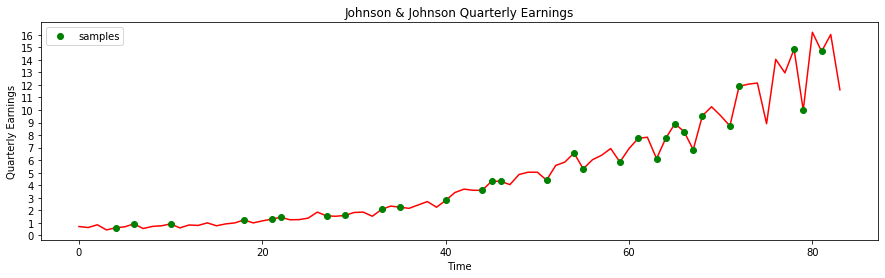

In [25]:
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(df.index.values, df["x"], "r-");
ax.set_ylabel("Quarterly Earnings")
ax.set_xlabel("Time")
ax.set_title("Johnson & Johnson Quarterly Earnings")
start, end = round(min(df["x"])), max( df["x"])  + 1
ax.yaxis.set_ticks(np.arange(start, end, 1))



ax.plot(sampled_X_train, sampled_y_train, 'og', label='samples')
plt.legend()
plt.savefig("figures/problem-4-1.png", bbox_inches="tight")
plt.show()

In [26]:
def kernel(x, y, scal, par_SE, par_pol):
    return scal[0]*K_SE(x, y, par_SE) +scal[1]*K_linear(x, y) + \
            scal[2]*K_poly(x, y, par_pol) + scal[3]*K_cos(x, y)

SCAL = [[100, .1, .1, .1],
        [.1, 100, .1, .1],
        [.1, .1, 100, .1],
        [.1, .1, .1, 100],
        [50, 50, .1, 50]]

# Sampling

rmse = 2.4982946200722167
rmse = 0.9353793878547503
rmse = 0.9354048947970263
rmse = 0.9218182893632514
rmse = 2.339911292182234


<Figure size 720x288 with 0 Axes>

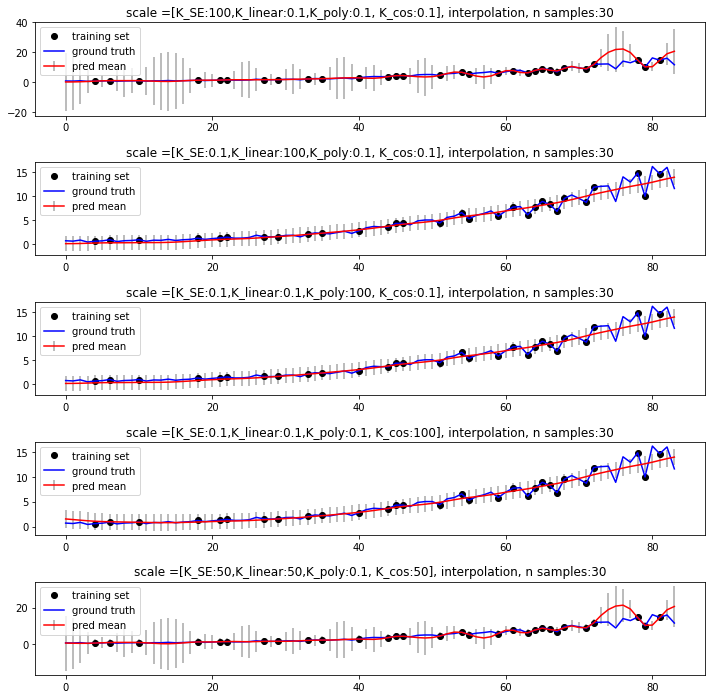

In [27]:
plt.figure(figsize=(10,4))

fig, ax = plt.subplots(len(SCAL), 1, figsize=(12,12))
for ss in range(len(SCAL)):
    mus, cov = predict(time, sampled_X_train, sampled_y_train, kernel, 
                       SCAL[ss], par_SE, par_pol, cholesky=cholesky, beta_inv=beta_inv)
    sigmas = np.sqrt(np.diag(cov))
    plot_gp(time, mus, sigmas, sampled_X_train,sampled_y_train, true_y, ax=ax[ss])
    print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, true_y))))
    details = "scale =[K_SE:{},K_linear:{},K_poly:{}, K_cos:{}], interpolation, n samples:{}" \
        .format(np.str(SCAL[ss][0]), np.str(SCAL[ss][1]), np.str(SCAL[ss][2]), np.str(SCAL[ss][3]), training_data_num)
    ax[ss].set_title(details)
    
plt.subplots_adjust(hspace=0.5)
plt.savefig("figures/problem-4-2.png", bbox_inches="tight")    

rmse = 2.339911292182234
rmse = 2.3037155848470783
rmse = 2.3025541666397356
rmse = 1.0994434855565076
rmse = 1.102635941531185
rmse = 1.1050171274896765


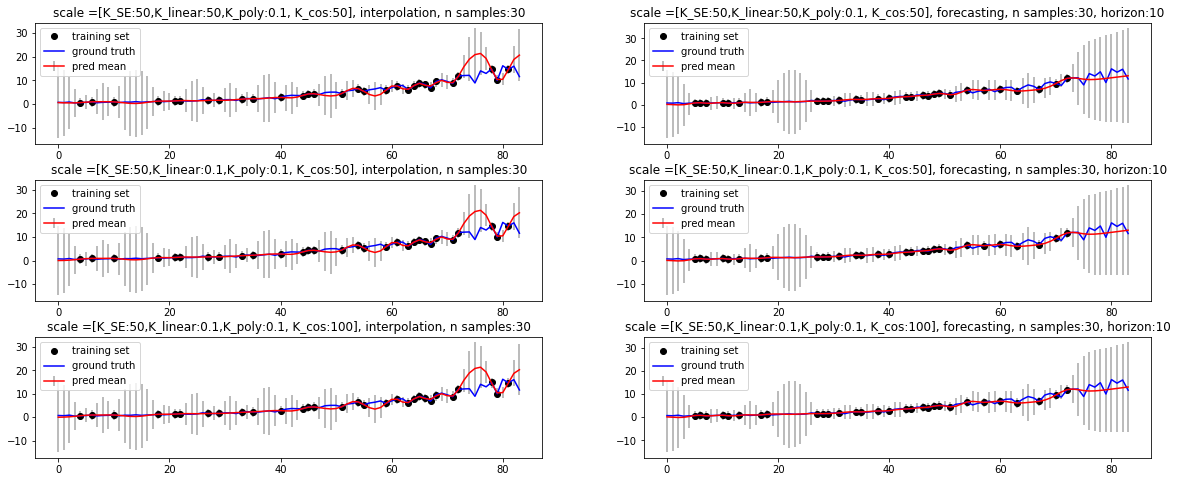

In [28]:
SCAL = [[50, 50, .1, 50],
        [50, .1, .1, 50],
        [50, .1, .1, 100]]


fig, ax = plt.subplots(len(SCAL), 2, figsize=(20,8))
for ss in range(len(SCAL)):
    mus, cov = predict(time, sampled_X_train, sampled_y_train, kernel, SCAL[ss], par_SE, par_pol, cholesky=cholesky, beta_inv=beta_inv)
    sigmas = np.sqrt(np.diag(cov))
    plot_gp(time, mus, sigmas, sampled_X_train, sampled_y_train, true_y, ax=ax[ss][0])
    print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, true_y))))
    details = "scale =[K_SE:{},K_linear:{},K_poly:{}, K_cos:{}], interpolation, n samples:{}" \
        .format(np.str(SCAL[ss][0]), np.str(SCAL[ss][1]), np.str(SCAL[ss][2]), np.str(SCAL[ss][3]), training_data_num)
    ax[ss][0].set_title(details)

for ss in range(len(SCAL)):
    mus, cov = predict(time, f_nsamp, f_y_train, kernel, SCAL[ss], par_SE, par_pol, cholesky=cholesky, beta_inv=beta_inv)
    sigmas = np.sqrt(np.diag(cov))
    plot_gp(time, mus, sigmas,f_nsamp, f_y_train, true_y, ax=ax[ss][1], legendon=False)
    details = "scale =[K_SE:{},K_linear:{},K_poly:{}, K_cos:{}], forecasting, n samples:{}, horizon:{}" \
        .format(np.str(SCAL[ss][0]), np.str(SCAL[ss][1]), np.str(SCAL[ss][2]), np.str(SCAL[ss][3]), training_data_num, horizon)
    ax[ss][1].set_title(details)
    print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, true_y))))
    ax[ss][1].legend(loc="upper left")
    
plt.subplots_adjust(hspace=0.3)
plt.savefig("figures/problem-4-3.png", bbox_inches="tight") 

In [29]:
gpy_f_n_train = 30
gpy_horizon = 10
gpy_f_df = df.index.values[:-gpy_horizon]
gpy_f_nsamp = np.random.choice(gpy_f_df, gpy_f_n_train, replace=False)
gpy_f_y_train = df.iloc[gpy_f_nsamp,:]
train_x = torch.from_numpy(gpy_f_nsamp)
train_x = train_x.type(torch.float32)
train_y = torch.from_numpy(np.array(gpy_f_y_train.values).reshape(-1))
train_y = train_y.type(torch.float32)

In [30]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGPModel(train_x, train_y, likelihood)

In [31]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print("Iter %d/%d - Loss: %.3f" % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 4.305
Iter 2/100 - Loss: 3.682
Iter 3/100 - Loss: 3.271
Iter 4/100 - Loss: 3.077
Iter 5/100 - Loss: 2.967
Iter 6/100 - Loss: 2.879
Iter 7/100 - Loss: 2.801
Iter 8/100 - Loss: 2.730
Iter 9/100 - Loss: 2.666
Iter 10/100 - Loss: 2.606
Iter 11/100 - Loss: 2.552
Iter 12/100 - Loss: 2.502
Iter 13/100 - Loss: 2.458
Iter 14/100 - Loss: 2.419
Iter 15/100 - Loss: 2.383
Iter 16/100 - Loss: 2.352
Iter 17/100 - Loss: 2.323
Iter 18/100 - Loss: 2.297
Iter 19/100 - Loss: 2.271
Iter 20/100 - Loss: 2.246
Iter 21/100 - Loss: 2.221
Iter 22/100 - Loss: 2.195
Iter 23/100 - Loss: 2.170
Iter 24/100 - Loss: 2.145
Iter 25/100 - Loss: 2.120
Iter 26/100 - Loss: 2.095
Iter 27/100 - Loss: 2.072
Iter 28/100 - Loss: 2.048
Iter 29/100 - Loss: 2.025
Iter 30/100 - Loss: 2.001
Iter 31/100 - Loss: 1.978
Iter 32/100 - Loss: 1.954
Iter 33/100 - Loss: 1.930
Iter 34/100 - Loss: 1.906
Iter 35/100 - Loss: 1.881
Iter 36/100 - Loss: 1.856
Iter 37/100 - Loss: 1.831
Iter 38/100 - Loss: 1.805
Iter 39/100 - Loss: 1

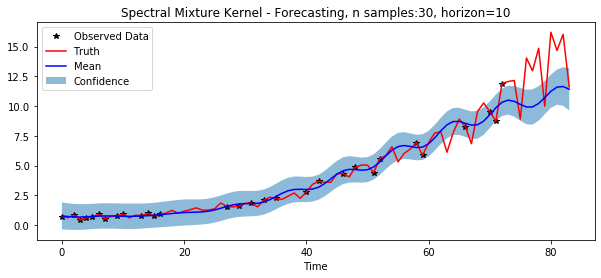

In [32]:
#### test_x = torch.linspace(0, 100, 100)
test_x = torch.from_numpy(df.index.values)
test_x = test_x.type(torch.float32)
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Make predictions
    observed_pred = likelihood(model(test_x))

    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 4))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(df.index.values, df["x"], "r-");
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_title("Spectral Mixture Kernel - Forecasting, n samples:{}, horizon={}".format(gpy_f_n_train, gpy_horizon))
    ax.set_xlabel("Time")
    ax.legend(['Observed Data', 'Truth', 'Mean', 'Confidence'])
plt.savefig("figures/problem-4-4.png", bbox_inches="tight") 

In [33]:
# plt.figure(figsize=(10,4))
# plt.pcolor(time, time, kernel(time, time, SCAL[1], par_SE, par_pol))
# plt.axis('square')
# plt.colorbar()
# plt.title('first kernel')
# plt.xlabel('time')
# plt.ylabel('time')

In [34]:
# fig, ax = plt.subplots(2,2, figsize=(15,10))
# im = ax[0,0].pcolor(time, time, K_SE(time, time, par_SE))
# ax[0,0].set_aspect(1)
# fig.colorbar(im, ax=ax[0,0])
# ax[0,0].set_title('SE kernel')
# ax[0,0].set_xlabel('time')

# im = ax[0,1].pcolor(time, time, K_linear(time, time))
# ax[0,1].set_aspect(1)
# fig.colorbar(im, ax=ax[0,1])
# ax[0,1].set_title('linear kernel')

# im = ax[1,0].pcolor(time, time, K_poly(time, time, par_pol))
# ax[1,0].set_aspect(1)
# fig.colorbar(im, ax=ax[1,0])
# ax[1,0].set_title('polynomial kernel')
# ax[1,0].set_xlabel('time')
# ax[1,0].set_ylabel('time')

# im = ax[1,1].pcolor(time, time, K_cos(time, time))
# ax[1,1].set_aspect(1)
# fig.colorbar(im, ax=ax[1,1])
# ax[1,1].set_title('cosine kernel')
# ax[1,1].set_ylabel('time')